In [1]:
import os
import site
import sqlite3
import sys
from time import sleep

import logzero
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from logzero import logger
from tqdm import tqdm
from tqdm.notebook import tqdm
from yaml import dump, load, safe_load

In [2]:
sys.path.append("../../sql")
import queries

sys.path.append("../source")
import ts_tools

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
plt.rcParams["figure.figsize"] = 30, 25
plt.rcParams["ytick.labelsize"] = 11
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelpad"] = 12
plt.rcParams["axes.xmargin"] = 0.01
plt.rcParams["axes.ymargin"] = 0.01

In [5]:
log_path = "logs/"
log_file = "ts_arima.log"

logzero.logfile(log_path + log_file, maxBytes=1e6, backupCount=5, disableStderrLogger=True)
logger.info(f"{log_path}, {log_file}\n")

In [6]:
configs = None
try:
    with open("../configs/config.yml", "r") as config_in:
        configs = load(config_in, Loader=yaml.SafeLoader)
        logger.info(f"{configs}\n")
except:
    logger.error(f"config file open failure.")
    exit(1)

cfg_vars = configs["url_variables"]
logger.info(f"variables: {cfg_vars}\n")

years = configs["request_years"]
logger.info(f"years: {years}\n")

db_path = configs["file_paths"]["db_path"]

city = configs["location_info"]["city"]
state = configs["location_info"]["state"]
db_file = city + "-" + state + ".db"

db_table1 = configs["table_names"]["db_table1"]
db_table2 = configs["table_names"]["db_table2"]

logger.info(f"{db_path}, {db_file}")

nrows = configs["num_rows"][0]
logger.info(f"number of rows: {nrows}\n")

In [7]:
conn = sqlite3.connect(db_path + db_file)
cursor = conn.cursor()

In [8]:
cursor.execute(queries.select_distinct_zips)
distinct_zipcodes = cursor.fetchall()
distinct_zipcodes = [z[0] for z in distinct_zipcodes]
logger.info(f"distinct zip codes:\n{distinct_zipcodes}")
print(distinct_zipcodes)

['73108', '73109', '73110', '73115', '73119', '73129', '73130', '73135', '73139', '73145', '73149', '73150', '73159', '73160', '73165']


In [9]:
zipcode_index = 9
params = {"zipcode": distinct_zipcodes[zipcode_index]}

select_nsr_rows = f"""
SELECT date_time,
-- year, month, day, 
-- zipcode,
-- Clearsky_DHI, DHI,
Clearsky_DNI, DNI,
Clearsky_GHI, GHI,
Temperature,
Relative_Humidity,
Precipitable_Water,
-- Wind_Direction,
Wind_Speed
from nsrdb
where zipcode = :zipcode
-- and not (month = 2 and day = 29)
-- and year = 2000
;
"""

df = pd.read_sql(
    select_nsr_rows,
    conn,
    params=params,
    index_col="date_time",
    parse_dates=["date_time"],
)

df.sort_index(axis=0, inplace=True)
# df.head(5)

In [10]:
df_rsm = df.resample("M").mean().reset_index(drop=False)
df_rsm.set_index("date_time", inplace=True)
# df_rsm

In [13]:
columns = df.columns.tolist()
print(columns)
f_idx_a = "DNI"
f_idx_b = "GHI"
f_idx_c = "Temperature"
f_idx_d = "Relative_Humidity"

features = [f_idx_a, f_idx_b, f_idx_c, f_idx_d]
print(features)

['Clearsky_DNI', 'DNI', 'Clearsky_GHI', 'GHI', 'Temperature', 'Relative_Humidity', 'Precipitable_Water', 'Wind_Speed']
['DNI', 'GHI', 'Temperature', 'Relative_Humidity']


In [14]:
df_varmax = df_rsm[features]

In [15]:
varmax_order = ts_tools.gen_varmax_params(
    p_rng=(12, 12),
    q_rng=(12, 12),
    debug=True,
)

VARMA Order list length: 1


In [16]:
results = ts_tools.VARMAX_optimizer(df_varmax, varmax_order, debug=False)
best_order = results.iloc[0]["(p, q)"]

best_order
# (6, 3)

  0%|          | 0/1 [00:00<?, ?it/s]

(12, 12)

In [17]:
forecast = ts_tools.varmax_model(
    df_varmax.iloc[:252],
    *best_order,
    num_fc=23,
    forecast=True,
    summary=False,
)

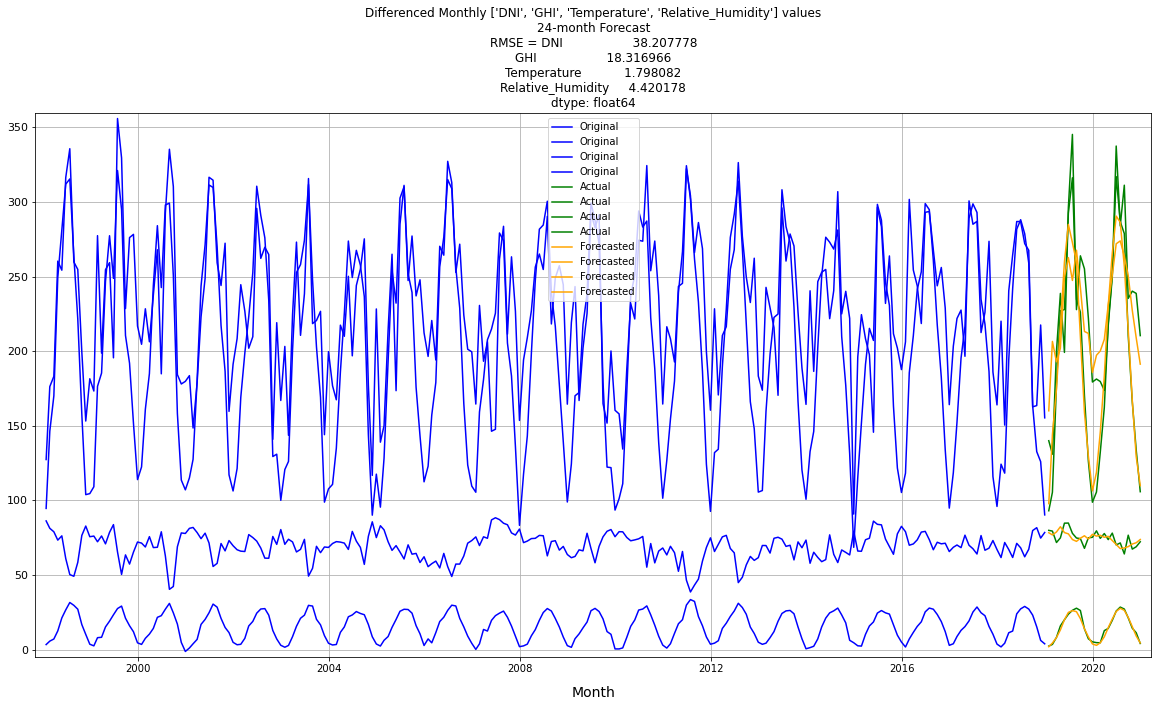

In [18]:
actual = df_varmax.iloc[252:]

rmse = np.sqrt(np.mean((actual - forecast) ** 2))

fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(df_varmax.iloc[:252], label="Original", color="blue")
ax.plot(actual, label="Actual", color="green")
ax.plot(forecast, label="Forecasted", color="orange")

ax.set_xlabel("Month")

ax.set_title(
    f"{city.upper()}, {state.upper()} {distinct_zipcodes[zipcode_index]}\n"
    + f"Differenced Monthly {features} values\n"
    + f"{len(forecast)}-month Forecast\n"
    + f"RMSE = {rmse}"
)

ax.grid()
ax.legend();

In [19]:
model = ts_tools.varmax_model(
    df_varmax,
    *best_order,
    forecast=False,
    summary=False,
)

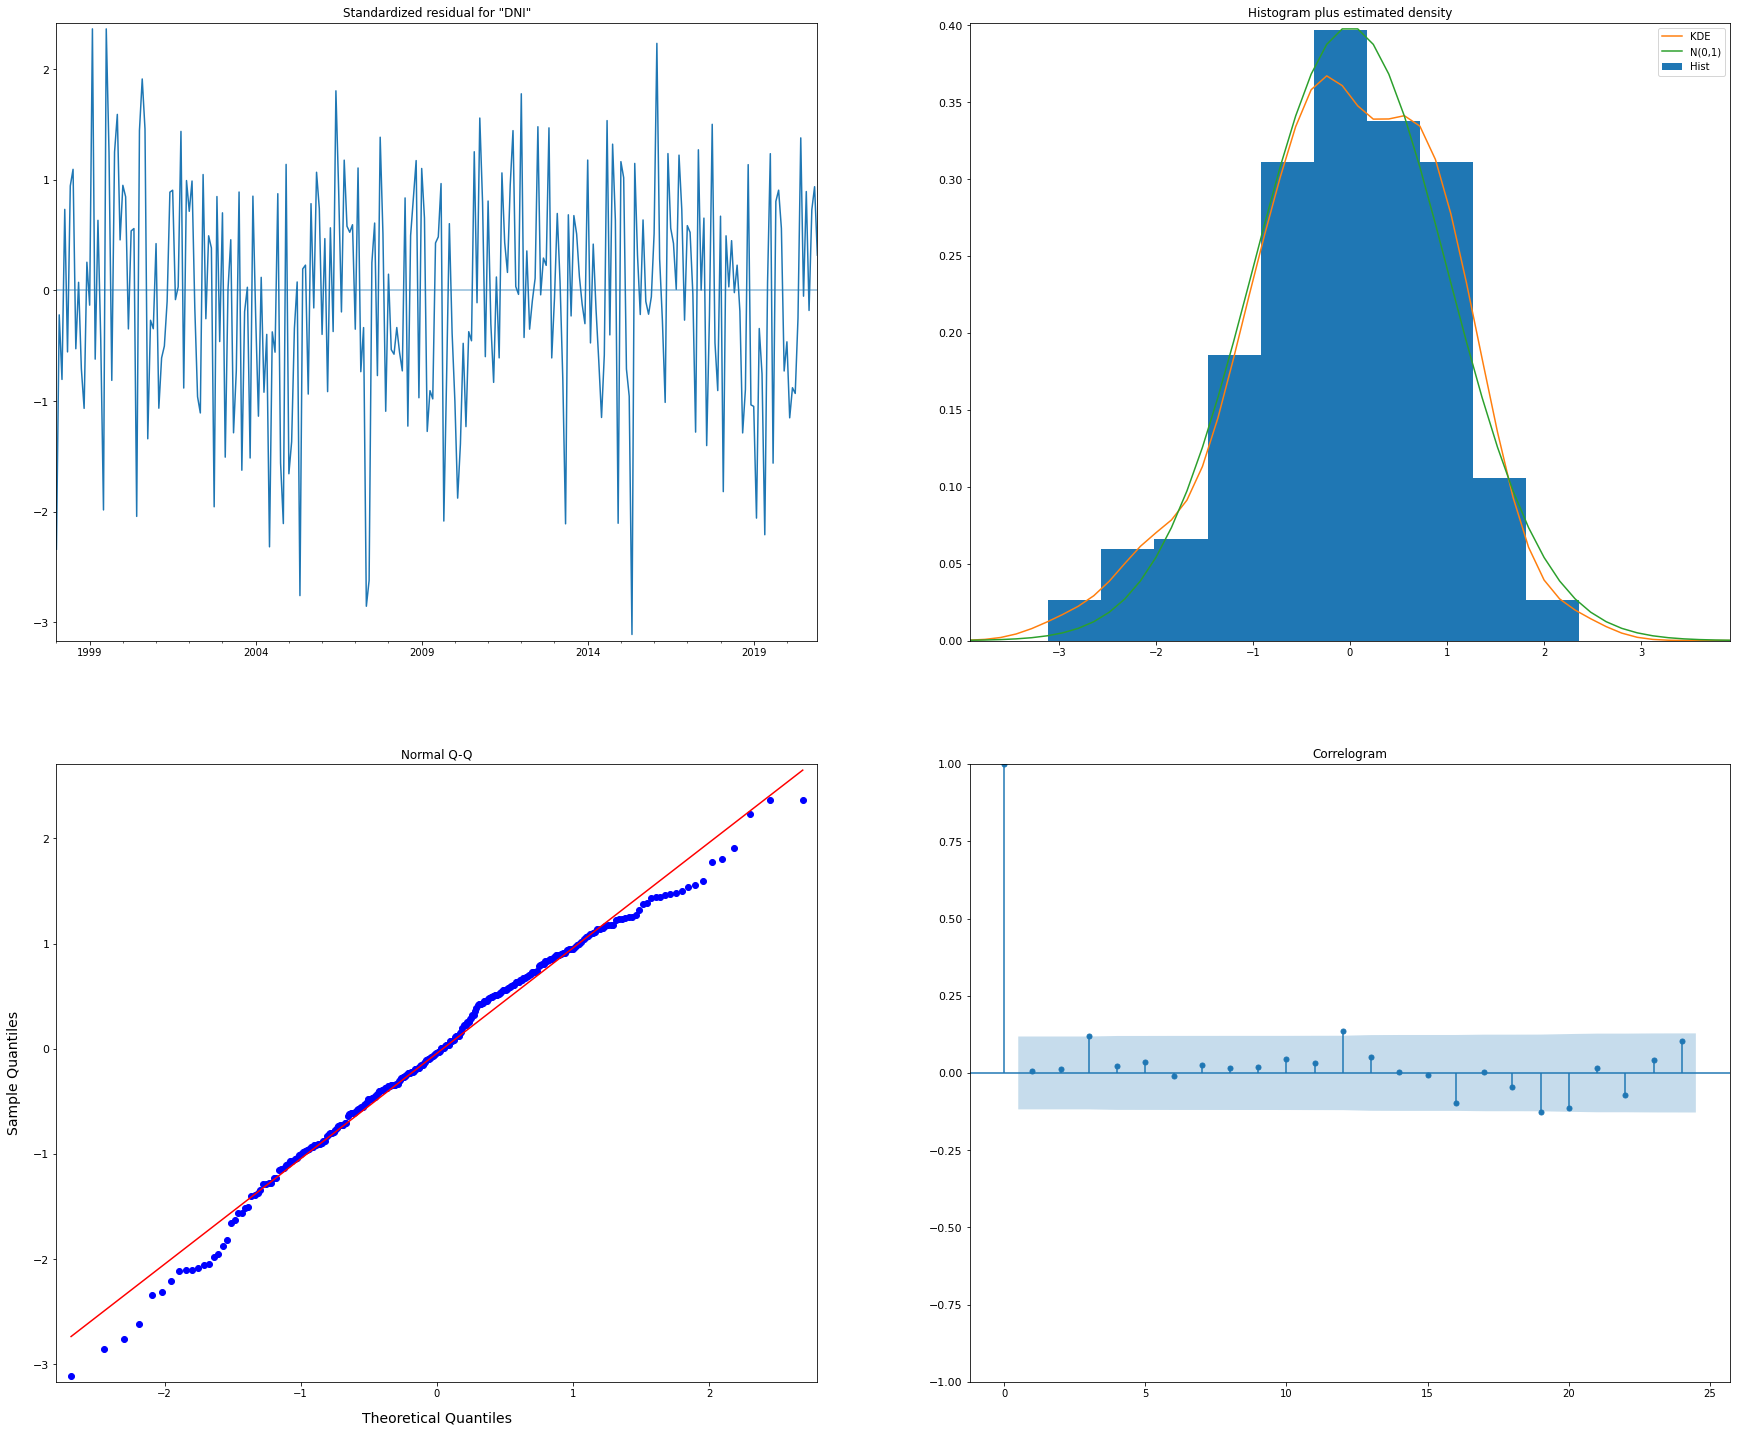

In [20]:
model.plot_diagnostics(lags=24);